In [88]:
import sys
import pandas as pd
import pickle
sys.path.append('../')
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from scipy.stats import norm, chisquare

%matplotlib inline

In [2]:
from api.utils.transformers import *

In [3]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

### Generate Training Data

In [45]:
db_path = '../../Welcome-Centre-DataCorps-Data/ClientDatabaseStructure.mdb.sqlite'
conn = sqlite3.connect(db_path)
sql = """SELECT Referral.ClientId, EthnicityDescription, CountryDescription,
count(Referral.ReferralInstanceId) as referral_count
FROM Client
LEFT JOIN Ethnicity on Client.ClientEthnicityID = Ethnicity.EthnicityID
LEFT JOIN Country on CLIent.ClientCountryID = Country.CountryId
LEFT JOIN Referral on Referral.ClientId = Client.ClientId
GROUP BY 1,2,3"""

In [46]:
df = pd.read_sql(sql, conn)

In [56]:
df = df.dropna(subset=['ClientId'])

df[['EthnicityDescription', 'CountryDescription']] = df[['EthnicityDescription', 'CountryDescription']].fillna('NULL')

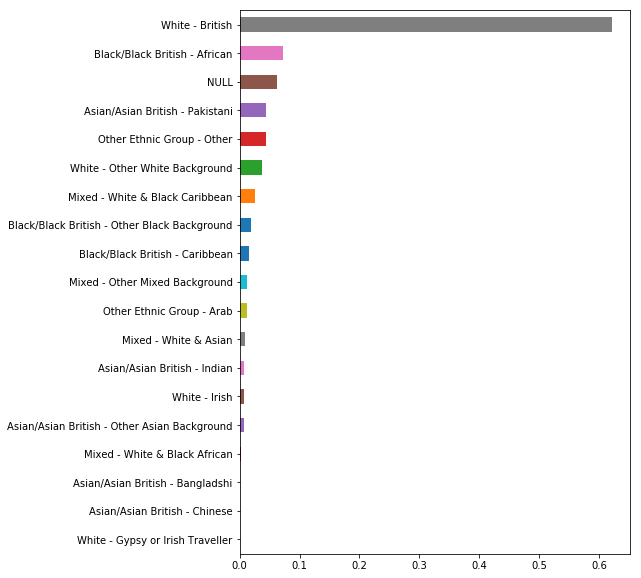

In [63]:
df['EthnicityDescription'].value_counts(normalize=True).sort_values().plot(kind='barh', figsize=(7,10))

In [77]:
df['EthnicityDescription'].value_counts().sort_values(ascending=False)

White - British                                 3339
Black/Black British - African                    387
NULL                                             334
Asian/Asian British - Pakistani                  235
Other Ethnic Group - Other                       234
White - Other White Background                   203
Mixed - White & Black Caribbean                  137
Black/Black British - Other Black Background     101
Black/Black British - Caribbean                   86
Mixed - Other Mixed Background                    68
Other Ethnic Group - Arab                         68
Mixed - White & Asian                             49
Asian/Asian British - Indian                      39
White - Irish                                     38
Asian/Asian British - Other Asian Background      36
Mixed - White & Black African                     14
Asian/Asian British - Bangladshi                   5
Asian/Asian British - Chinese                      2
White - Gypsy or Irish Traveller              

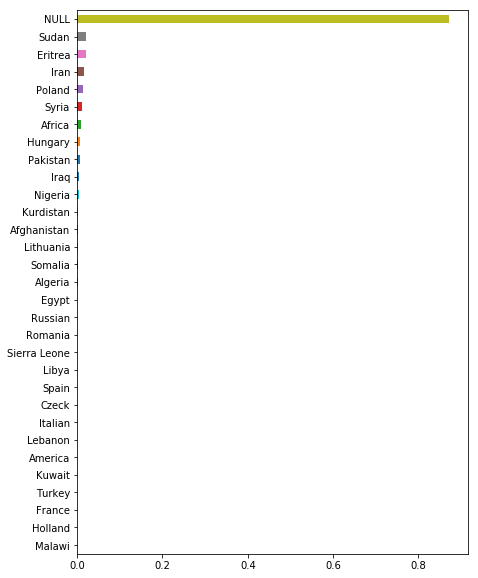

In [64]:
df['CountryDescription'].value_counts(normalize=True).sort_values().plot(kind='barh', figsize=(7,10))

Text(0.5,0,'Average Number of Referrals')

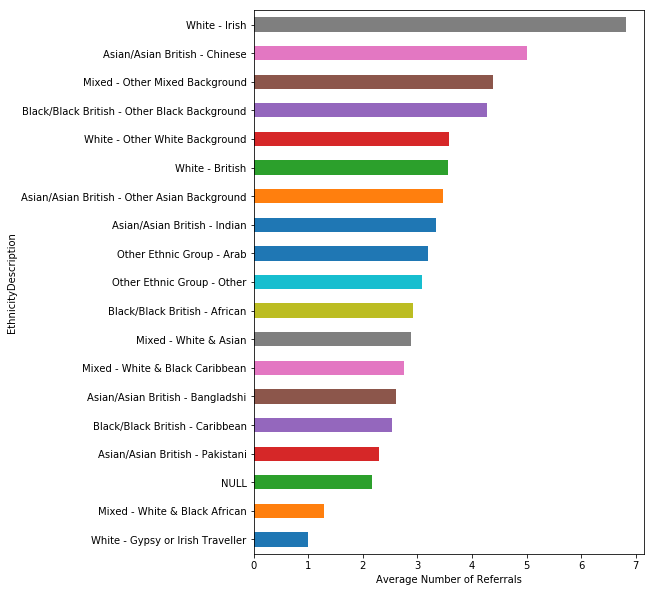

In [70]:
ax = df.groupby('EthnicityDescription')['referral_count'].mean().sort_values().plot(kind='barh', figsize=(7,10))

ax.set_xlabel('Average Number of Referrals')

Text(0.5,0,'Average Number of Referrals')

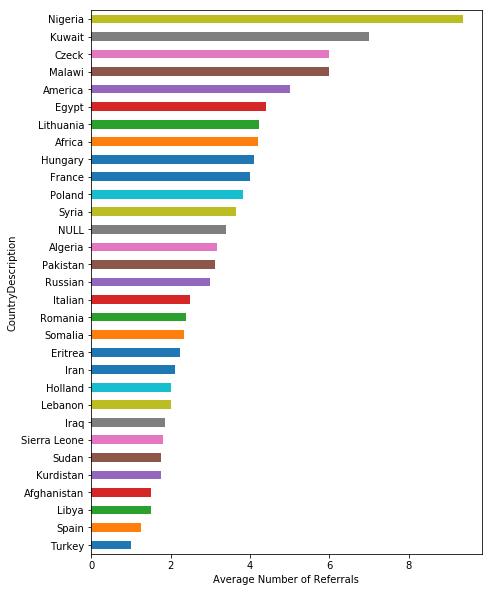

In [71]:
ax = df.groupby('CountryDescription')['referral_count'].mean().sort_values().plot(kind='barh', figsize=(7,10))

ax.set_xlabel('Average Number of Referrals')

In [89]:
def calculate_z_stats_by_category(df, variable_column_name, category_column_name):
    """Given a dataframe with a random variable in variable_column_name and a category in 
        category_column_name, return the z statistics for the observed means of the variable 
        for each category"""
    pop_mean = df[variable_column_name].mean()
    pop_var =  df[variable_column_name].var()
    out = (df.groupby(category_column_name)[variable_column_name]
            .apply(calculate_sample_z_score, pop_mean, pop_var).unstack())
    out['pop_size'] = df[variable_column_name].count()
    out['pop_mean'] = pop_mean
    out['pop_var'] = pop_var
    return out

def calculate_sample_z_score(sample_series, pop_mean, pop_variance):
    """Given a series of values of a  random variable sampled from a population
        return the z_score of the mean of that sample"""
    sample_mean = sample_series.mean()
    n = sample_series.count()
    z_score = calculate_z_score(sample_mean, pop_mean, pop_variance, n)
    p_value = convert_z_score_to_p_value(z_score)
    index = (sample_mean - pop_mean)/pop_mean
    return pd.Series([sample_mean, index, n, p_value, z_score],
                     index=['sample_mean', 'index', 'sample_size', 'p_value', 'z_score'])

def calculate_z_score(sample_mean, pop_mean, pop_variance, sample_size):
    """Calculates the Z-score for a sample mean taken from a population with known mean and 
        variance"""
    return (sample_mean - pop_mean) / np.sqrt(pop_variance / sample_size)

def convert_z_score_to_p_value(z_score, two_tailed=True):
    """For a given z_score return the p-value based on one or two tailed test"""
    if two_tailed:
        if z_score <= 0:
            return 2 * norm.cdf(z_score)
        elif z_score > 0:
            return 2 * (1 - norm.cdf(z_score))
    else:
        return norm.cdf(z_score)


In [94]:
sig = calculate_z_stats_by_category(df, 'referral_count','CountryDescription')
sig['Significant'] = sig['p_value'] < 0.05
sig.sort_values('sample_mean', ascending=False)

,sample_mean,index,sample_size,p_value,z_score,pop_size,pop_mean,pop_var,Significant
CountryDescription,,,,,,,,,
Nigeria,9.363636,1.799717,22.0,3.481654e-09,5.907108,5376,3.344494,22.842418,True
Kuwait,7.000000,1.092992,2.0,2.794029e-01,1.081662,5376,3.344494,22.842418,False
Malawi,6.000000,0.793993,1.0,5.784721e-01,0.555618,5376,3.344494,22.842418,False
Czeck,6.000000,0.793993,4.0,2.664669e-01,1.111236,5376,3.344494,22.842418,False
America,5.000000,0.494994,2.0,6.242308e-01,0.489863,5376,3.344494,22.842418,False
Egypt,4.400000,0.315595,5.0,6.214285e-01,0.493827,5376,3.344494,22.842418,False
Lithuania,4.222222,0.262440,9.0,5.816696e-01,0.550948,5376,3.344494,22.842418,False
Africa,4.192308,0.253495,52.0,2.008343e-01,1.279178,5376,3.344494,22.842418,False
Hungary,4.093750,0.224027,32.0,3.751773e-01,0.886817,5376,3.344494,22.842418,False


In [101]:
df[df['EthnicityDescription']=="White - Irish"].sort_values('referral_count').sum()

ClientId                                                            99600
EthnicityDescription    White - IrishWhite - IrishWhite - IrishWhite -...
CountryDescription      NULLNULLNULLNULLNULLNULLNULLNULLNULLNULLNULLNU...
referral_count                                                        259
dtype: object

In [96]:
sig = calculate_z_stats_by_category(df, 'referral_count','EthnicityDescription')
sig['Significant'] = sig['p_value'] < 0.05
sig.sort_values('sample_mean', ascending=False)

,sample_mean,index,sample_size,p_value,z_score,pop_size,pop_mean,pop_var,Significant
EthnicityDescription,,,,,,,,,
White - Irish,6.815789,1.037913,38.0,0.000008,4.477260,5376,3.344494,22.842418,True
Asian/Asian British - Chinese,5.000000,0.494994,2.0,0.624231,0.489863,5376,3.344494,22.842418,False
Mixed - Other Mixed Background,4.382353,0.310319,68.0,0.073342,1.790695,5376,3.344494,22.842418,False
Black/Black British - Other Black Background,4.267327,0.275926,101.0,0.052320,1.940495,5376,3.344494,22.842418,False
White - Other White Background,3.586207,0.072272,203.0,0.471174,0.720571,5376,3.344494,22.842418,False
White - British,3.565139,0.065973,3339.0,0.007638,2.667667,5376,3.344494,22.842418,True
Asian/Asian British - Other Asian Background,3.472222,0.038191,36.0,0.872606,0.160349,5376,3.344494,22.842418,False
Asian/Asian British - Indian,3.333333,-0.003337,39.0,0.988365,-0.014583,5376,3.344494,22.842418,False
Other Ethnic Group - Arab,3.191176,-0.045842,68.0,0.791371,-0.264530,5376,3.344494,22.842418,False
